In [1]:
import pandas as pd
import numpy as np
import random
import os
import re
import matplotlib.pyplot as plt
import seaborn as sb
import re
import gensim
import nltk
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import string
from textblob import Word
from gensim import corpora
from pprint import pprint
from sklearn.model_selection import train_test_split
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel
from gensim.utils import simple_preprocess, lemmatize
from gensim.models.tfidfmodel import TfidfModel
from gensim import corpora, models
from sklearn.feature_extraction.text import CountVectorizer
import copy
from sklearn.decomposition import NMF

d:\Users\Khaled-Khodja\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


stopwords_english = set(ENGLISH_STOP_WORDS)
ponctuations = string.punctuation

In [2]:
sb.set()

In [3]:
def tagsPredictLDA(nbreTopics, corpus_train, corpus_test, dictionary, Tags_train_vect, Tags_test, dictionnaire_tags):
    
    
    lda_model = LdaModel(corpus = corpus_train, 
                         id2word = dictionary,  
                         num_topics = nbreTopics)
    
    #Création de la matrice Topics par Tags depuis le jeu d'entrainement
    topics_vocabulary_array = lda_model.get_topics()
    quest_topics = Quest_train_vect.dot(topics_vocabulary_array.transpose())
    topics_tags = quest_topics.transpose().dot(Tags_train_vect.toarray())
    
    #Matrice Topics et Phi-Value
    topics_vect_test  = lda_model[corpus_test]

    nbreTagsPredict = 6
    array = np.zeros((len(topics_vect_test), lda_model.num_topics))
    for i, c in enumerate(topics_vect_test):
        for numTopic, phiValue in c:
            array[i][numTopic] = phiValue
    
    
    TagsPredictArray = array.dot(topics_tags)
    ordreTags = np.argsort(TagsPredictArray)
    tagsPredict = []
    for listeTags in ordreTags:
        l = []
        for t in listeTags[::-1][:nbreTagsPredict]:
            l.append(dictionnaire_tags[t])
        tagsPredict.append(l)
    
    tagsPredict = [",".join(t) for t in tagsPredict]

    tags_predict = predictTags(corpus_test, topics_tags, topics_tags, lda_model)
    Tags_test_Predict = Tags_test.copy()
    Tags_test_Predict["TagsPredict"] = tags_predict
    Tags_test_Predict["Precision"] = Tags_test_Predict[["TagsCleaned", "TagsPredict"]].apply(lambda x: precision(x["TagsCleaned"], x["TagsPredict"]), axis = 1)
    Tags_test_Predict["Rappel"] = Tags_test_Predict[["TagsCleaned", "TagsPredict"]].apply(lambda x: rappel(x["TagsCleaned"], x["TagsPredict"]), axis = 1)
    
    return Tags_test_Predict

In [4]:
def precision(label, labelPredit):
    """
    label: chaine de caractere séparé comportant éventuellement des virgules
    labelPredit: 
    """
    labelCommun = set(label.split(",")).intersection(labelPredit.split(","))
    
    return len(labelCommun) / len(labelPredit.split(","))


def rappel(label, labelPredit):
    
    labelCommun = set(label.split(",")).intersection(labelPredit.split(","))
    
    return len(labelCommun) / len(label.split(","))

In [5]:
def predictTags(corpus_test,  dictionaire_tags, topics_tags, lda_model):
    """
    Paramètres:
     - corpus_test : BOW version Gensim: liste de liste de mot et chaque mot est un tuple avec comme
         premier nombre son id et en second, le nombre de fois où il apparait dans le corpus.
    - dictionnaires tags
    - lda_model
                    
    """
    topics_vect  = lda_model[corpus_test]
    nbreTagsPredict = 6

    #Construction d'un numpy Array
    array = np.zeros((len(topics_vect), lda_model.num_topics))
    for i, c in enumerate(topics_vect):
        for numTopic, phiValue in c:
            array[i][numTopic] = phiValue
        
    TagsPredictArray = array.dot(topics_tags)
    ordreTags = np.argsort(TagsPredictArray)
    tagsPredict = []
    for listeTags in ordreTags:
        l = []
        for t in listeTags[::-1][:nbreTagsPredict]:
            l.append(dictionnaire_tags[t])
        tagsPredict.append(l)
    
    tagsPredict = [",".join(t) for t in tagsPredict]
    
    return tagsPredict


In [6]:
#Nettoyage de la colonne Tags
#Supression des chevrons
class AnalyseTags:
    """
    Classe possédant un ensemble de méthode 
    pour un "nettoyage" des tags
    """
    
    def __init__(self):
        self.tags = None
        self.tagsCleaned = None
    
    
    def eliminationChevrons(self, tags):
        """
        Renvoi une chaine de caractères en éliminant les chevrons "<" et ">"
        argument:
            tags: chaîne de caractères
        """
        return tags.replace("><", ",").replace("<", "").replace(">", "")

    
    def splitTags(self, tags):
        """
        renvoie une chaine de caractéres (format str)
        en séparant les mots qui comporte un "-" (tiret)
        arguments:
            tags: de format str correspondant à une liste de mots séparés par des virgule 
        """
        tags = tags.split(",")
        tags2 = []
        for t in tags:
            if "-" in t:
                for t2 in t.split("-"):
                    tags2.append(t2)
            else:
                tags2.append(t)
        
        tags2 = [t.lower().strip() for t in tags2]
        
        return ",".join(sorted(tags2))

    
    def filtreTags(self, tags):
        """
        Renvoie une chaine de caractère correspondant à une liste de mots séparé par des virgules
        Elle élimine les mots:
        + de 1 caractères
        + les nombre
        + les tags commençant par une lettre puis des nombres
        argument:
            tags: chaîne de catactères composés de mot séparés par des virgules
        """
        tags = tags.split(",")
        tags2 = []
        patern1 =re.compile(r"\w?[0-9]+(\.)?.*")
        patern2 = re.compile(r"\s+")
        patern3 = re.compile(r"(.+\.){2,}.+")
        for t in tags:
            if patern1.match(t):
                pass
            elif patern2.match(t):
                pass
            elif patern3.match(t):
                pass
            elif len(t) <= 1:
                pass
            else:
                tags2.append(t)
        
        tags2 = [t.lower().strip() for t in tags2]
        
        return ",".join(sorted(set(tags2)))
    
    
    def nettoieTags(self, tags):
        """
        Applique les 3 fonctions successivement sur la chaîne de caractères:
        - Elimination des chevrons
        - Séparation des tags comportants un tiret
        - Suppression des tags correspondant un certains critère (voir méthode "filtreTags")
        """
        self.tags = tags
        self.tagsCleaned = self.eliminationChevrons(self.tags)
        self.tagsCleaned = self.splitTags(self.tagsCleaned)
        self.tagsCleaned = self.filtreTags(self.tagsCleaned)
        return self.tagsCleaned
    
    
    def frequenceTags(self, tags, freqTags = {}):
        """
        Renvoi un dictionnaire en répertoriant les mot en 
        Argument:
        - tags: 
        """
        for t in tags.split(","):
            if t in freqTags:
                freqTags[t] += 1
            else:
                freqTags[t] = 1
        return freqTags

In [7]:
class AnalyseTitleBodyCode():
    
    def __init__(self):
        """
        
        """
        self.title_body = None
        
    
    def splitQuestionCode(self, texte):
        """
        """
        texte = re.sub(r"\n", " ", texte)
        codes = re.findall(r"<code>.*?</code>", texte)
        code = ""
        for c in codes:
            code += c
        #suppression des portions de code dans la question
        question = re.sub(r"<code>.*?</code>", " ", texte)
        
        return question, code
    
    
    def eliminationBalise(self, texte):
        """
        """
        expressions_regulieres = [r"\n", r"<.*?>", r"\r", r"(\w+\/)+[\w+\.]+", r'https?://[\S]+', 
                                  r"(\w+\.)+\w+", r"\$\w+", r'\b(\w)\1+\b', r"  +", r"\b[0-9]+\b"] 
        for motif in expressions_regulieres:
            texte = re.sub(motif, " ", texte)
        
        return texte
    
    
    def tokenisation(self, texte):
        """
        """
        texteTokenise = nltk.word_tokenize(eliminationBalise(t))
    
        return " ".join(texteTokenise)

    
    def suppressionPonctuation(self, texte):
        """
        """
        texte = re.sub(r"[^\w\s]"," ",texte)
        
        return texte
    
    def lowerCase(self, texte):
        """
        """
        return texte.lower()
    
    
    def suppressionStopWord(self, texte):
        """
        """
        texteTokenise = []
        for m in texte.split():
            if not(m in set(ENGLISH_STOP_WORDS)):
                texteTokenise.append(m)
        
        return " ".join(texteTokenise)
    
    
    def lemmatisation(self, texte):
        """
        """
        texteTokenise = []
        for m in texte.split(" "):
            texteTokenise.append(Word(m).lemmatize())
            
        return " ".join(texteTokenise)
    
    def stemmatisation(self, texte):
        """
        """
        texteTokenise = []
        for m in texte.split(" "):
            texteTokenise.append(Word(m).stem())
            
        return " ".join(texteTokenise)
    
    
    def suppressionEspace(self, texte):
        texte = re.sub(r"(\s){2,}", " ", texte)
        
        return texte
    
    
    def nettoyageTexte(self, texte):
        """
        """
        texte = self.eliminationBalise(texte)
        texte = self.lowerCase(texte)
        texte = self.suppressionPonctuation(texte)
        texte = self.suppressionStopWord(texte)
        texte = self.lemmatisation(texte)
        texte = self.stemmatisation(texte)
        texte = self.suppressionEspace(texte)
        texte = self.suppressionMotLongueur(texte, 2, 20)
        
        return texte
    
    
    def suppressionMotLongueur(self, texte, longueurMin = 1, longueurMax = 25):
        
        texteTokenise = []
        for m in texte.split():
            if len(m) > longueurMin and len(m) < longueurMax:
                texteTokenise.append(m)
                
        return " ".join(texteTokenise)
        
    def nettoyageCode(self, code):
        
        #code = self.eliminationBalise(code)
        code = self.lowerCase(code)
        code = self.suppressionPonctuation(code)
        code = self.suppressionEspace(code)
        code = self.suppressionMotLongueur(code, 2, 25)
        
        return code

In [8]:
repScript = os.getcwd()

<CENTER><H2>CHARGEMENT DU FICHIER</H2></CENTER>

In [9]:
#Ouverture du fichier
annees = [2018]
data = pd.DataFrame()
for year in annees:
    data_0 = pd.read_csv(os.path.join(os.path.dirname(repScript), "donnees", "QueryResults_{}.csv".format(year)))
    data = pd.concat([data, data_0])
data = data.reset_index(drop = True)
data_0 = None

<CENTER><H3>VISUALISATION DES DONNEES</H3></CENTER>

In [10]:
data.head()

,CreationDate,ViewCount,Title,Body,Tags
0,2018-01-21 19:36:48,1580,How to copy the value of variable in javascript,<p>I'm trying to copy string variable to clipb...,<javascript><copy><clipboard>
1,2018-01-21 19:37:46,2974,Pixi.js - Draw Rectangle with Gradient Fill,"<p>I'm using the <a href=""http://www.pixijs.co...",<javascript><gradient><pixi.js><pixijs>
2,2018-01-21 19:37:59,207,Capture Textbox value through a CheckBox asp.n...,<p>There is a Form which consists of Textbox w...,<c#><asp.net-mvc><checkbox><textbox>
3,2018-01-21 19:38:57,368,discordapp.com/api/users/@me/guilds sometimes ...,<p>In my application users login with Discord ...,<discord>
4,2018-01-21 19:40:31,370,Class Parcelable with ArrayList of Objects,<p>I'm trying to use Parcelable on a class tha...,<java><android><object><arraylist><parcelable>


<CENTER><H2>ANALYSE DES TAGS</H2></CENTER>

<CENTER><H3>NETTOYAGE DES TAGS</H3></CENTER>

In [11]:
analysetags = AnalyseTags()

In [12]:
data["TagsCleaned"] = data["Tags"].apply(analysetags.nettoieTags)

<CENTER><H3>ANALYSE DES TAGS</H3></CENTER>

In [13]:
freqTags = {}
for tags in list(data["TagsCleaned"]):
    freqTags = analysetags.frequenceTags(tags, freqTags)

<CENTER><H3>FREQUENCE DES TAGS</H3></CENTER>

In [14]:
dataFreqTags = pd.DataFrame({"tag": list(freqTags.keys()), "freq": list(freqTags.values())})
dataFreqTags = dataFreqTags.sort_values("freq", ascending = False)

In [15]:
"Il y a {} tags dans notre base de données".format(len(dataFreqTags))

'Il y a 9738 tags dans notre base de données'

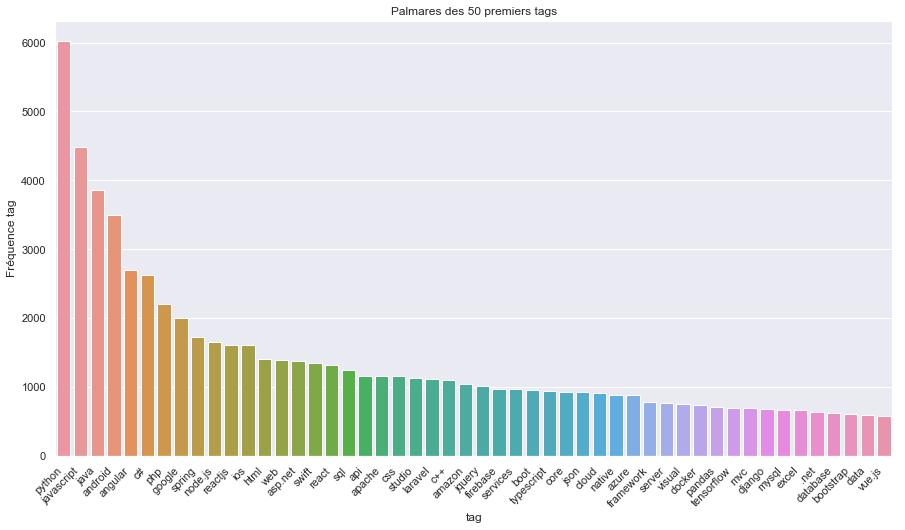

In [16]:
plt.figure(figsize = (15, 8))
sb.barplot(x = dataFreqTags['tag'][:50], y = dataFreqTags['freq'])
plt.title("Palmares des 50 premiers tags")
plt.xticks(rotation = 45, horizontalalignment = "right")
plt.ylabel("Fréquence tag")
plt.savefig("FreqTag.png", dpi = 300)

Détermination d'un seuil pour éliminer les tags les moins fréquents:
+ Difficulté pour prédire des tags dont la présence dans la base de donnée est très faible
+ Choix du tags par l'utilisateur peu usité par la communauté (peut-être est-ce un mauvais choix)

In [17]:
dataFreqTags.describe()

,freq
count,9738.000000
mean,19.134422
std,129.630505
min,1.000000
25%,1.000000
50%,2.000000
75%,7.000000
max,6016.000000


+ 50% des tags ont une fréquence comprise entre 1 et 8 !!!
+ le tag le plus fréquent est python avec 6 084 apparitions

(0, 22)

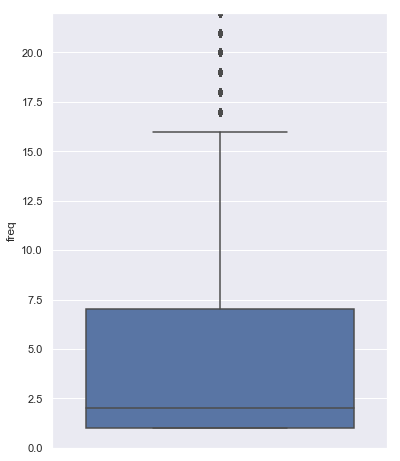

In [18]:
plt.figure(figsize = (6, 8))
sb.boxplot(dataFreqTags["freq"], orient = "v")
plt.ylim((0, 22))

On cherche un seuil de freq de tags qui n'éliminera pas de manière excessive des questions qui n'auraient plus de tags

In [19]:
reponse = {}
for seuil in range(200):
    TagsFiltre = []
    for tags in list(data["TagsCleaned"]):
        tags2 = []
        for tag in tags.split(","):
            if freqTags[tag] > seuil:
                tags2.append(tag)
        TagsFiltre.append(",".join(tags2))
    
    nbre = 0
    for i in TagsFiltre:
        if len(i) == 0:
            nbre += 1
    reponse[seuil] = round(nbre / len(data) * 100, 2)

In [20]:
df_reponse = pd.DataFrame({"seuil": list(reponse.keys()), "nbreQuestionsSansTags": list(reponse.values())})

Text(0.5, 0, 'Fréquence minimum du tag')

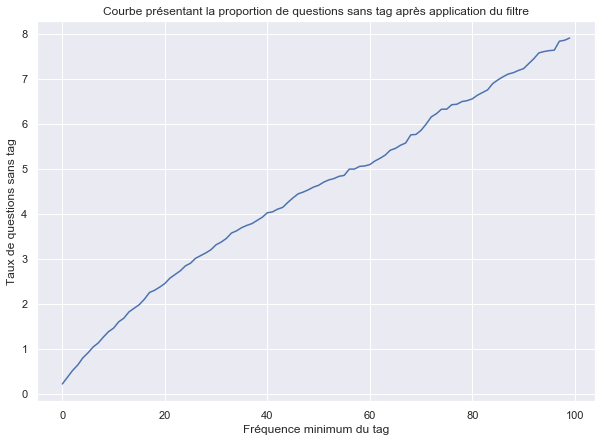

In [21]:
seuil = 100
plt.figure(figsize = (10, 7))
plt.plot(range(seuil),df_reponse[["nbreQuestionsSansTags"]][:seuil])
plt.title("Courbe présentant la proportion de questions sans tag après application du filtre")
plt.ylabel("Taux de questions sans tag")
plt.xlabel("Fréquence minimum du tag")

Au vu du graphique, pour une base de donnée comportant 47 000 questions nous éliminons les tags présents moins de 60 fois. Cela correspond à un élimination d'environ 3% des questions.

<CENTER><H3>SUPPRESSION DES TAGS PRESENTS MOINS DE 60 FOIS ET SUPPRESSION DES QUESTIONS SANS TAGS</H3></CENTER>

In [22]:
listeTags = []
seuil = 60
for tags in list(data['TagsCleaned']):
    listeTags2 = []
    for tag in tags.split(","):
        if freqTags[tag] >= seuil:
            listeTags2.append(tag)
    listeTags.append(",".join(listeTags2))
    
data["TagsCleaned"] = listeTags
print("Nombre de questions supprimées: {}".format(len(data[data["TagsCleaned"] == ""])))
print("Proportion du nombre de questions supprimées: {}%".format(round(len(data[data["TagsCleaned"] == ""]) / len(data) * 100, 2)))
data = data[data["TagsCleaned"] != ""]

Nombre de questions supprimées: 2529
Proportion du nombre de questions supprimées: 5.06%


<CENTER><H3>NOMBRE DE TAGS PAR QUESTION</H3></CENTER>

In [23]:
nbreTagsQuestion = []
for tags in list(data["TagsCleaned"]):
    nbreTagsQuestion.append(len(tags.split(",")))

In [24]:
maxTags = max(nbreTagsQuestion)
print(max(nbreTagsQuestion))

9


Après le traitement, le nombre de tags par question oscille entre 1 et 9. Le mode s'établissant à 2. 

([<matplotlib.axis.XTick at 0xd9005c0>,
 <a list of 10 Text xticklabel objects>)

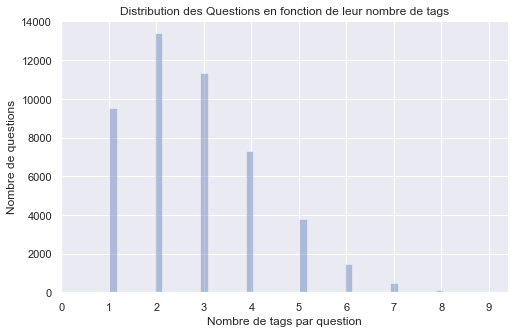

In [25]:
plt.figure(figsize = (8, 5))
sb.distplot(nbreTagsQuestion, kde = False)
plt.title("Distribution des Questions en fonction de leur nombre de tags")
plt.xlabel("Nombre de tags par question")
plt.ylabel("Nombre de questions")
plt.xticks(range(maxTags + 1), range(maxTags + 1))

In [26]:
df_nbreTagQuest = pd.DataFrame({"Nbre Tags": nbreTagsQuestion, "Nbre Question": 1}).groupby("Nbre Tags").count()
df_nbreTagQuest["%"] = round(df_nbreTagQuest["Nbre Question"] / df_nbreTagQuest["Nbre Question"].sum() * 100, 2 )
df_nbreTagQuest["%cum"] = df_nbreTagQuest["%"].cumsum()
df_nbreTagQuest

,Nbre Question,%,%cum
Nbre Tags,,,
1,9546,20.11,20.11
2,13383,28.19,48.30
3,11360,23.93,72.23
4,7323,15.43,87.66
5,3778,7.96,95.62
6,1474,3.11,98.73
7,469,0.99,99.72
8,114,0.24,99.96
9,24,0.05,100.01


Dans la suite de ce projet, nous spécifierons le nombre de tags à prédire au nombre de 6 --> 98 % des sont composés d'au plus de 6 tags

In [27]:
compteur = 0 
for tag, freq in freqTags.items():
    if freq >=60:
        compteur += 1
"Il reste {} tags après avoir effectué le filtre".format(compteur)

'Il reste 482 tags après avoir effectué le filtre'

<CENTER><H2>ANALYSE DES QUESTIONS</H2></CENTER>

Choix de fusionner titre et question dans une seule colonne
+ separation du texte et du code
+ suppression des balises
+ transformation des caracteres en minuscules
+ suppression des ponctuations
+ suppression des mots vides
+ lemmatisation des mots

In [28]:
%%time
codes = []
title_body = []
traitementTexte = AnalyseTitleBodyCode()
for i, row in data.iterrows():
    question, code = traitementTexte.splitQuestionCode(row['Title'] + row["Body"])
    codes.append(traitementTexte.nettoyageCode(code))
    title_body.append(traitementTexte.nettoyageTexte(question))
    
data["Title_Body_Cleaned"] = title_body
data["Code_Cleaned"] = codes

Wall time: 2min 36s


<B>ABANDON de la partie  "CODE" car cela déteriore les performance du modèle</B>fusion des colonnes "title_body_cleaned" et "code_cleaned"

In [29]:
#data["Title_Body_Code_Cleaned"] = data["Title_Body_Cleaned"] + data["Code_Cleaned"]

In [30]:
data["Title_Body_Code_Cleaned"] = data["Title_Body_Cleaned"]

<CENTER><H3>FREQUENCE DES MOTS</H3></CENTER>

In [31]:
freqMots = {}
for doc in list(data["Title_Body_Code_Cleaned"]):
    for mot in doc.split():
        if mot in freqMots.keys():
            freqMots[mot] += 1
        else:
            freqMots[mot] = 1

In [32]:
df_freqMots = pd.DataFrame({"mot": list(freqMots.keys()), "freq": list(freqMots.values())}).sort_values("freq", ascending = False)

In [33]:
df_freqMots.describe()

,freq
count,52399.000000
mean,43.405580
std,507.100584
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,51524.000000


(0, 8)

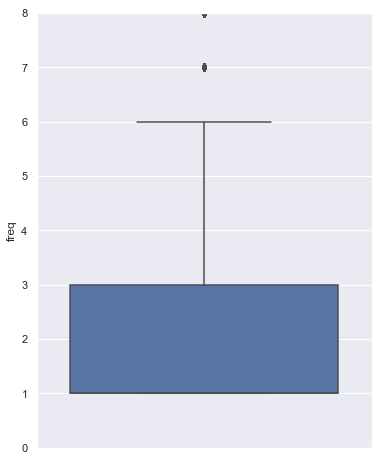

In [34]:
plt.figure(figsize = (6, 8))
sb.boxplot(df_freqMots["freq"], orient = "v")
plt.ylim((0, 8))

In [35]:
df_freqMots[["freq"]].quantile([i / 100 for i in range(0, 100, 5)])

,freq
0.00,1.0
0.05,1.0
0.10,1.0
0.15,1.0
0.20,1.0
0.25,1.0
0.30,1.0
0.35,1.0
0.40,1.0
0.45,1.0


+ 50 % des mots n'apparaissent qu'une fois dans tout le corpus

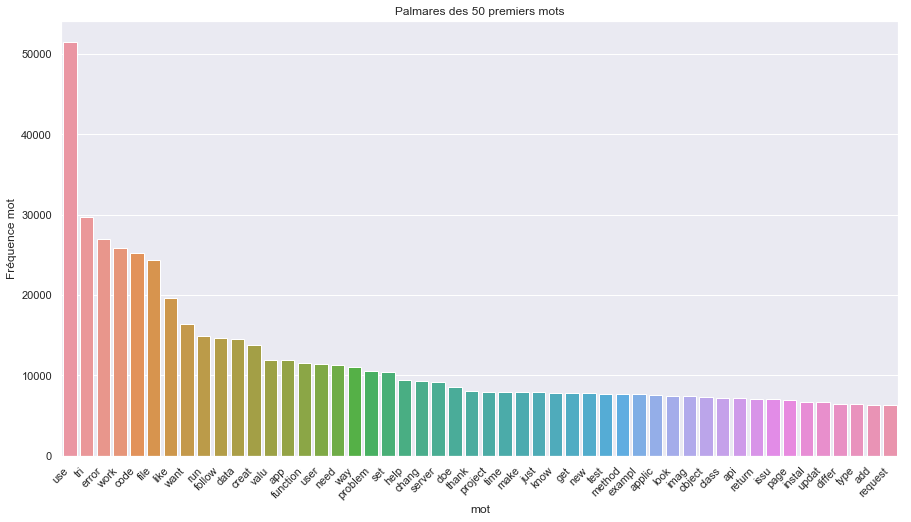

In [36]:
plt.figure(figsize = (15, 8))
sb.barplot(x = df_freqMots['mot'][:50], y = df_freqMots['freq'])
plt.title("Palmares des 50 premiers mots")
plt.xticks(rotation = 45, horizontalalignment = "right")
plt.ylabel("Fréquence mot")
plt.savefig("freqMot.png", dpi = 300)

In [37]:
freqDocMot = {}
for doc in list(data["Title_Body_Code_Cleaned"]):
    for mot in set(doc.split()):
        if mot in freqDocMot:
            freqDocMot[mot] += 1
        else:
            freqDocMot[mot] = 1

df_freqDocMot = pd.DataFrame({"mot": list(freqDocMot.keys()), "freqDocMot": list(freqDocMot.values())}).sort_values(by = "freqDocMot", ascending = False)

In [38]:
df_freqDocMot.describe()

,freqDocMot
count,52399.000000
mean,28.136606
std,313.294052
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,26952.000000


In [39]:
df_freqDocMot[['freqDocMot']].quantile([i / 100 for i in range(0, 100, 5)])

,freqDocMot
0.00,1.0
0.05,1.0
0.10,1.0
0.15,1.0
0.20,1.0
0.25,1.0
0.30,1.0
0.35,1.0
0.40,1.0
0.45,1.0


+ 75% des mots ne figurent que dans un seul document

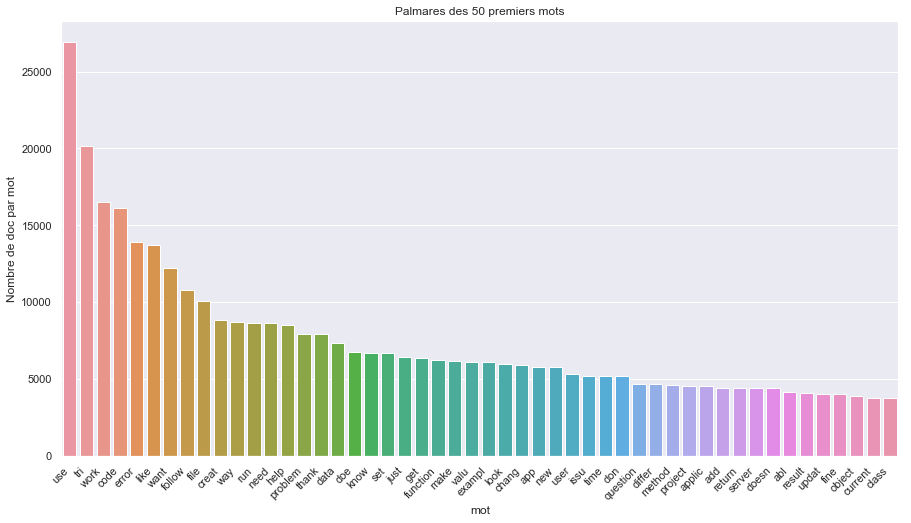

In [40]:
plt.figure(figsize = (15, 8))
sb.barplot(x = df_freqDocMot['mot'][:50], y = df_freqDocMot['freqDocMot'])
plt.title("Palmares des 50 premiers mots")
plt.xticks(rotation = 45, horizontalalignment = "right")
plt.ylabel("Nombre de doc par mot")
plt.savefig("freqDocMot.png", dpi = 300)

<CENTER><H2>RECHERCHE D'UN MODELE</H2></CENTER>

<CENTER><H2>CREATION JEU ENTRAINEMENT ET JEU TEST</H2></CENTER>

Création d'un jeu d'entrainement et d'un jeu de test, conjointement pour:
+ la base "Title_Body_Code_Cleaned"
+ la base "Tags_Cleaned"

In [41]:
Quest_train, Quest_test, Tags_train, Tags_test = train_test_split(data[['Title_Body_Code_Cleaned']], data[['TagsCleaned']], test_size = 0.2)

<CENTER><H3>COUNT VECTORISOR - VECTORISATION DU TAGS_TRAIN</H3></CENTER>

In [42]:
countVectorizor_tags = CountVectorizer(token_pattern = "[^,]+").fit(Tags_train['TagsCleaned'])
Tags_train_vect = countVectorizor_tags.transform(Tags_train['TagsCleaned'])

In [43]:
dictionnaire_tags = countVectorizor_tags.get_feature_names()

In [44]:
#Nombre de tags présents dans le jeu d'entrainement
"Nombre de tags dans le dictionnaire: {}".format(len(dictionnaire_tags))

'Nombre de tags dans le dictionnaire: 481'

<CENTER><H3>COUNT VECTORISOR - VECTORISATION DU TAGS_TEST</H3><CENTER>

In [45]:
Tags_test_vect = countVectorizor_tags.transform(Tags_test['TagsCleaned'])

<CENTER><H3>CREATION DU DICTIONNAIRE</H3></CENTER>

In [46]:
titleBodyCodeCleaned = [[m for m in q.split()] for q in list(Quest_train["Title_Body_Code_Cleaned"]) ] 
dictionary = corpora.Dictionary(titleBodyCodeCleaned)

In [47]:
dictionary_backup = copy.copy(dictionary)
"Il y a {} mots dans le corpus".format(len(dictionary.token2id))

'Il y a 45075 mots dans le corpus'

In [48]:
#On élimine les mots qui sont présent dans 1 ou 2 documents
#On élimine les mots présents dans 99% ou plus des documents
dictionary.filter_extremes(no_below=3, no_above=0.03)

"Il reste {} mots dans le corpus".format(len(dictionary.token2id))

'Il reste 9821 mots dans le corpus'

<CENTER><H3>COUNT VECTORISOR - VECTORISATION DU QUEST_TRAIN</H3></CENTER>

In [49]:
#Construire un numpy Array documents par vocabulaire
CountVectorizer_Quest = CountVectorizer(vocabulary = dictionary.token2id).fit(Quest_train["Title_Body_Code_Cleaned"])
#Construction d'une matrice numpy Array documents par vocabulaire
Quest_train_vect = CountVectorizer_Quest.transform(Quest_train["Title_Body_Code_Cleaned"])

<CENTER><H3>COUNT VECTORISOR - VECTORISATION DU QUEST_TEST</H3></CENTER>

In [50]:
Quest_test_vect = CountVectorizer_Quest.transform(Quest_test["Title_Body_Code_Cleaned"])

<CENTER><H2>TOPIC MODELING AVEC LDA</H2></CENTER>

<CENTER><H3>RECHERCHE DU NOMBRE DE "TOPICS" OPTIMAL LDA</H3></CENTER>

Plusieurs leviers:
+ le nombre de tags retenus
+ le dictionnaires: jouer sur les seuils de TDF (term document frequency) --> Influence le corpus
+ sur le nombre de Topics
+ sur la "forme" du corpus: BoW, TFIDF

<CENTER><H3>RECHERCHE DU NOMBRE DE TOPICS OPTIMALS AVEC CORPUS BOW</H3></CENTER>

In [51]:
%%time
repsLDA_bow = []
#Model LDA avec un corpus BoW
#Création BoW pour le jeu d'entrainement
tokenized_list = [simple_preprocess(doc) for doc in list(Quest_train['Title_Body_Code_Cleaned'])]
corpus_bow_train = [dictionary.doc2bow(doc, allow_update = False) for doc in tokenized_list]
#Création BoW pour le jeu de test
tokenized_list_test = [simple_preprocess(doc) for doc in list(Quest_test['Title_Body_Code_Cleaned'])]
corpus_bow_test = [dictionary.doc2bow(doc, allow_update = False) for doc in tokenized_list_test]

precision_lda_bow = []
rappel_lda_bow = []

for nbreTopics in range(100, 1700, 100):
    #Prédiction des tags avec le modèle LDA et le BoW
    repLDA_bow = tagsPredictLDA(nbreTopics, corpus_bow_train, corpus_bow_test, dictionary, Tags_train_vect, Tags_test, dictionnaire_tags)
    repsLDA_bow.append(repLDA_bow)
    print("****Nombre Topics {} ****".format(nbreTopics))
    print(repLDA_bow["Precision"].mean())
    print(repLDA_bow["Rappel"].mean())
    precision_lda_bow.append(repLDA_bow["Precision"].mean())
    rappel_lda_bow.append(repLDA_bow["Rappel"].mean())

d:\Users\Khaled-Khodja\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\models\ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


****Nombre Topics 100 ****
0.12608390380902124
0.30091756730777325
****Nombre Topics 200 ****
0.1476040021063738
0.3434606768808993
****Nombre Topics 300 ****
0.15769703352642053
0.3658770698028214
****Nombre Topics 400 ****
0.173231525364231
0.39712371590728657
****Nombre Topics 500 ****
0.18318413199930234
0.41757219756429925
****Nombre Topics 600 ****
0.19213621204143036
0.4368581208154676
****Nombre Topics 700 ****
0.19564683166579386
0.44421178230814906
****Nombre Topics 800 ****
0.2010531858873144
0.45451461504384166
****Nombre Topics 900 ****
0.20598560645954556
0.46868435350267956
****Nombre Topics 1000 ****
0.2125153589608613
0.4827237393114158
****Nombre Topics 1100 ****
0.21383184131999802
0.4847330675292762
****Nombre Topics 1200 ****
0.21649991223451445
0.4907809039009678
****Nombre Topics 1300 ****
0.22116903633491738
0.5013220408402079
****Nombre Topics 1400 ****
0.21930840793400472
0.49753015371498754
****Nombre Topics 1500 ****
0.21995787256451227
0.49893410901309787
*

In [52]:
a = np.array(precision_lda_bow) * np.array(rappel_lda_bow)
b = np.array(precision_lda_bow) + np.array(rappel_lda_bow)
c = a / b
F_score = 2 * c

In [53]:
nTopics = [i for i in range(100, 1700, 100)]

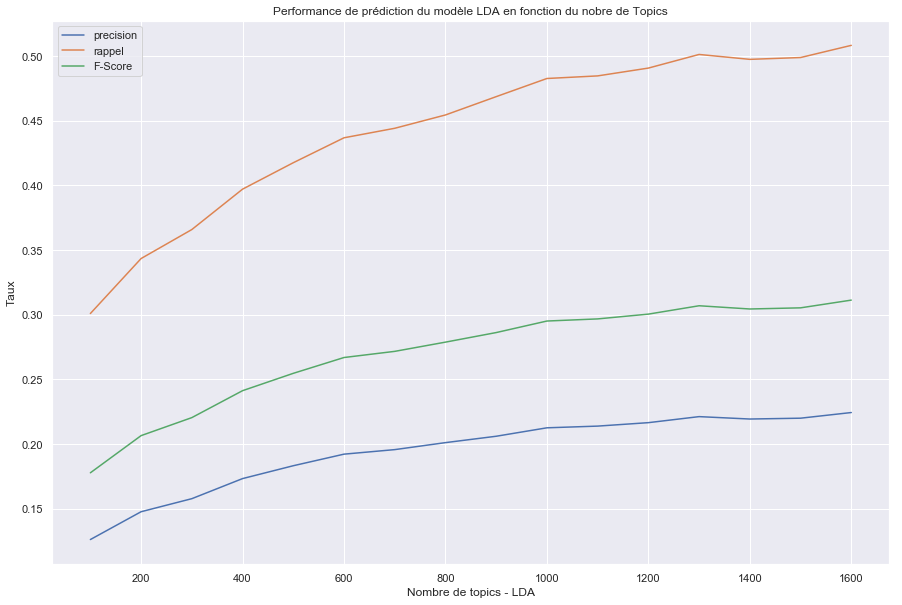

In [54]:
plt.figure(figsize = (15, 10))
plt.plot(nTopics, precision_lda_bow, label = "precision")
plt.plot(nTopics, rappel_lda_bow, label= "rappel")
plt.plot(nTopics, F_score, label = "F-Score")
plt.title("Performance de prédiction du modèle LDA en fonction du nobre de Topics")
plt.xlabel("Nombre de topics - LDA")
plt.ylabel("Taux")
plt.legend()
plt.savefig("performance_lda.png", dpi = 300)

<CENTER><H3>RECHERCHE DU NOMBRE DE MOTS OPTIMUM A CONSERVER</H3></CENTER>

In [55]:
%%time
repsLDA_bow = []

filtreDoc = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

precision_lda_bow2 = []
rappel_lda_bow2 = []

for i in filtreDoc:    
    dictionary = corpora.Dictionary(titleBodyCodeCleaned)
    dictionary.filter_extremes(no_below=3, no_above=i)
    #Construire un numpy Array documents par vocabulaire
    CountVectorizer_Quest = CountVectorizer(vocabulary = dictionary.token2id).fit(Quest_train["Title_Body_Code_Cleaned"])
    #Construction d'une matrice numpy Array documents par vocabulaire
    Quest_train_vect = CountVectorizer_Quest.transform(Quest_train["Title_Body_Code_Cleaned"])
    Quest_test_vect = CountVectorizer_Quest.transform(Quest_test["Title_Body_Code_Cleaned"])

    #Model LDA avec un corpus BoW
    #Création BoW pour le jeu d'entrainement
    tokenized_list = [simple_preprocess(doc) for doc in list(Quest_train['Title_Body_Code_Cleaned'])]
    corpus_bow_train = [dictionary.doc2bow(doc, allow_update = False) for doc in tokenized_list]
    #Création BoW pour le jeu de test
    tokenized_list_test = [simple_preprocess(doc) for doc in list(Quest_test['Title_Body_Code_Cleaned'])]
    corpus_bow_test = [dictionary.doc2bow(doc, allow_update = False) for doc in tokenized_list_test]
    
    nbreTopics = 1300

    #Prédiction des tags avec le modèle LDA et le BoW
    repLDA_bow = tagsPredictLDA(nbreTopics, corpus_bow_train, corpus_bow_test, dictionary, Tags_train_vect, Tags_test, dictionnaire_tags)
    print("****max doc: {} ****".format(i))
    print(repLDA_bow["Precision"].mean())
    print(repLDA_bow["Rappel"].mean())
    precision_lda_bow2.append(repLDA_bow["Precision"].mean())
    rappel_lda_bow2.append(repLDA_bow["Rappel"].mean())
    

****max doc: 0.01 ****
0.2030191328769575
0.46515329705692987
****max doc: 0.02 ****
0.21962436370019808
0.497149961968286
****max doc: 0.03 ****
0.21827277514481755
0.4926074709329053
****max doc: 0.04 ****
0.20300157977883618
0.4645577455135119
****max doc: 0.05 ****
0.1962787431981791
0.44896420003845017
****max doc: 0.06 ****
0.18676496401615322
0.4301021423138337
****max doc: 0.07 ****
0.1790942601369188
0.414932629537686
****max doc: 0.08 ****
0.16757942776900506
0.3900549579143589
****max doc: 0.09 ****
0.16466561348078282
0.38497492414554146
****max doc: 0.1 ****
0.1575390556433241
0.37001120054832604
****max doc: 0.2 ****
0.13550991750043984
0.32286604478547687
****max doc: 0.3 ****
0.12280147446024063
0.2960436152695239
****max doc: 0.4 ****
0.11549938564156213
0.2814162424667952
****max doc: 0.5 ****
0.11242759347024282
0.27379255581467254
****max doc: 0.6 ****
0.10498507986659071
0.2587874152645083
****max doc: 0.7 ****
0.10500263296471256
0.2586880730877567
****max doc: 0.

In [56]:
f_score = 2 * np.array(precision_lda_bow2) * np.array(rappel_lda_bow2) / (np.array(precision_lda_bow2) + np.array(rappel_lda_bow2))

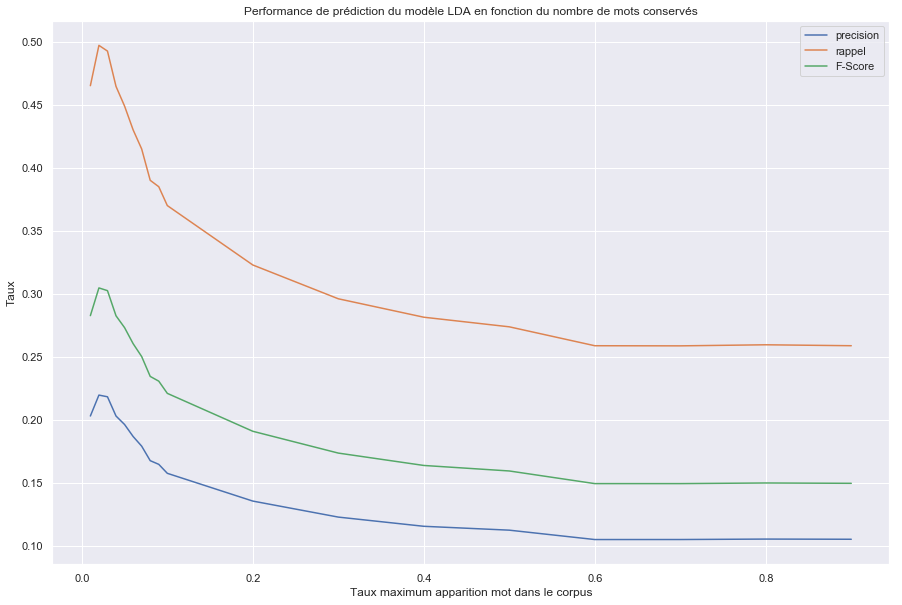

In [57]:
plt.figure(figsize = (15, 10))
plt.plot(filtreDoc, precision_lda_bow2, label = "precision")
plt.plot(filtreDoc, rappel_lda_bow2, label= "rappel")
plt.plot(filtreDoc, f_score, label = "F-Score")
plt.title("Performance de prédiction du modèle LDA en fonction du nombre de mots conservés")
plt.xlabel("Taux maximum apparition mot dans le corpus")
plt.ylabel("Taux")
plt.legend()
plt.savefig("performance_lda2.png", dpi = 300)

<CENTER><H3>CORPUS BOW</H3></CENTER>

In [58]:
%%time
#Model LDA avec un corpus BoW
nbreTopics = 1500
#Création BoW pour le jeu d'entrainement

tokenized_list = [simple_preprocess(doc) for doc in list(Quest_train['Title_Body_Code_Cleaned'])]
dictionary = copy.copy(dictionary_backup)
dictionary.filter_extremes(no_below=3, no_above=0.03)
CountVectorizer_Quest = CountVectorizer(vocabulary = dictionary.token2id).fit(Quest_train["Title_Body_Code_Cleaned"])
Quest_train_vect = CountVectorizer_Quest.transform(Quest_train["Title_Body_Code_Cleaned"])
corpus_bow_train = [dictionary.doc2bow(doc, allow_update = False) for doc in tokenized_list]
#Création BoW pour le jeu de test
tokenized_list_test = [simple_preprocess(doc) for doc in list(Quest_test['Title_Body_Code_Cleaned'])]
corpus_bow_test = [dictionary.doc2bow(doc, allow_update = False) for doc in tokenized_list_test]
#Prédiction des tags avec le modèle LDA et le BOW
repLDA_bow = tagsPredictLDA(nbreTopics, corpus_bow_train, corpus_bow_test, dictionary, Tags_train_vect, Tags_test, dictionnaire_tags)
print(repLDA_bow["Precision"].mean())
print(repLDA_bow["Rappel"].mean())

0.22297700544146448
0.5051306452017353
Wall time: 4min 14s


<CENTER><H3>CORPUS TFIDF</H3></CENTER>

In [59]:
%%time
#Model LDA avec un corpus TFIDF
nbreTopics = 1500
#Création BoW pour le jeu d'entrainement
tokenized_list = [simple_preprocess(doc) for doc in list(Quest_train['Title_Body_Code_Cleaned'])]
dictionary = copy.copy(dictionary_backup)
dictionary.filter_extremes(no_below=3, no_above=0.03)
CountVectorizer_Quest = CountVectorizer(vocabulary = dictionary.token2id).fit(Quest_train["Title_Body_Code_Cleaned"])
Quest_train_vect = CountVectorizer_Quest.transform(Quest_train["Title_Body_Code_Cleaned"])
corpus_bow_train = [dictionary.doc2bow(doc, allow_update = False) for doc in tokenized_list]
#Création TFIDF pour le jeu d'entrainement
tfidf = TfidfModel(corpus_bow_train)
corpus_tfidf_train = tfidf[corpus_bow_train]
#Création BoW pour le jeu de test
tokenized_list_test = [simple_preprocess(doc) for doc in list(Quest_test['Title_Body_Code_Cleaned'])]
corpus_bow_test = [dictionary.doc2bow(doc, allow_update = False) for doc in tokenized_list_test]
#Création du TFIDF pour le jeu de TEST
corpus_tfidf_test = tfidf[corpus_bow_test]
#Prediction avec le modèle LDA et le TFIDF
repLDA_tfidf = tagsPredictLDA(nbreTopics, corpus_tfidf_train, corpus_tfidf_test, dictionary, Tags_train_vect, Tags_test, dictionnaire_tags)
print(repLDA_tfidf["Precision"].mean())
print(repLDA_tfidf["Rappel"].mean())

d:\Users\Khaled-Khodja\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\models\ldamodel.py:582: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


0.00544146041776372
0.00813184884274933
Wall time: 4min 7s


<CENTER><H2>TOPIC MODELING AVEC NMF</H2></CENTER>

<CENTER><H3>RECHERCHE DU NOMBRE DE "TOPICS" OPTIMAL NMF</H3></CENTER>

In [ ]:
%%time
repNMF = []
for nbreTopicsNMF in range(100, 500, 100):

    nmf = NMF(n_components = nbreTopicsNMF, random_state=0)
    nmf.fit(Quest_train_vect)
    Quest_train_nmf = nmf.transform(Quest_train_vect)
    Quest_test_nmf = nmf.transform(Quest_test_vect)
    Topics_Tags_nmf = Quest_train_nmf.transpose().dot(Tags_train_vect.toarray())
    Quest_tags_test = Quest_test_nmf.dot(Topics_Tags_nmf)

    tagsPredit = []
    for i in range(len(Quest_tags_test)):
        t = []
        nbreTagsAPredire = 6
        for j in Quest_tags_test[i].argsort()[::-1][:nbreTagsAPredire]:
            t.append(dictionnaire_tags[j])
        tagsPredit.append(t)

    tagsPredict = [",".join(t) for t in tagsPredit]

    Tags_test_Predict = Tags_test.copy()
    Tags_test_Predict["TagsPredict"] = tagsPredict
    Tags_test_Predict["Precision"] = Tags_test_Predict[["TagsCleaned", "TagsPredict"]].apply(lambda x: precision(x["TagsCleaned"], x["TagsPredict"]), axis = 1)
    Tags_test_Predict["Rappel"] = Tags_test_Predict[["TagsCleaned", "TagsPredict"]].apply(lambda x: rappel(x["TagsCleaned"], x["TagsPredict"]), axis = 1)
    print("*****Nombre de Topics: {} *****".format(nbreTopicsNMF))
    print(Tags_test_Predict["Precision"].mean())
    print(Tags_test_Predict["Rappel"].mean())
    repNMF.append(Tags_test_Predict)


In [ ]:
plt.figure(figsize = (15, 10))
plt.plot(range(100,500,100), [repNMF[i]['Precision'].mean() for i in range(len(repNMF))], label = "precision")
plt.plot(range(100,500,100), [repNMF[i]['Rappel'].mean() for i in range(len(repNMF))], label= "rappel")
f_score_nmf = 2 * (np.array([repNMF[i]['Precision'].mean() for i in range(len(repNMF))]) * np.array([repNMF[i]['Rappel'].mean() for i in range(len(repNMF))])) / (np.array([repNMF[i]['Precision'].mean() for i in range(len(repNMF))]) + np.array([repNMF[i]['Rappel'].mean() for i in range(len(repNMF))]))
plt.plot(range(100,500,100), f_score_nmf, label = "F-Score")
plt.title("Performance de prédiction du modèle NMF en fonction du nombre de Topics")
plt.xlabel("Nombre de Topics")
plt.ylabel("Taux")
plt.legend()
plt.savefig("performance_nmf.png", dpi = 300)

<CENTER><H3><CENTER><H2>SVM CLASSIFIER</H2></CENTER></H3></CENTER>

In [60]:
titleBodyCodeCleaned = [[m for m in q.split()] for q in list(Quest_train["Title_Body_Code_Cleaned"]) ] 
dictionary = corpora.Dictionary(titleBodyCodeCleaned)
dictionary_backup = copy.copy(dictionary)
dictionary.filter_extremes(no_below=3, no_above=0.03)

In [61]:
CountVectorizer_Quest = CountVectorizer(vocabulary = dictionary.token2id).fit(Quest_train["Title_Body_Code_Cleaned"])
Quest_train_vect = CountVectorizer_Quest.transform(Quest_train["Title_Body_Code_Cleaned"])

In [62]:
Quest_test_vect = CountVectorizer_Quest.transform(Quest_test["Title_Body_Code_Cleaned"])

In [63]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [64]:
param_grid = {"estimator__alpha":[10 ** -i for i in range(1, 4)], 
              "estimator__l1_ratio" : [i / 100 for i in range(0, 30, 10)]}

In [65]:
sgdc = OneVsRestClassifier(SGDClassifier(loss = "log"))

<CENTER><H3>AVEC UNE MATRICE "COUNTVECTORIZOR"</H3></CENTER>

In [66]:
grid_search = GridSearchCV(sgdc, param_grid, cv = 3)
grid_search.fit(Quest_train_vect, Tags_train_vect)
print("Best_params: {}".format(grid_search.best_params_))
print("Best_score: {}".format(grid_search.best_score_))

Best_params: {'estimator__alpha': 0.001, 'estimator__l1_ratio': 0.1}
Best_score: 0.0821834843058774


In [67]:
sgdc = OneVsRestClassifier(SGDClassifier(loss = "log", alpha = 0.001, l1_ratio = 0.1))

In [68]:
sgdc.fit(Quest_train_vect, Tags_train_vect)

OneVsRestClassifier(estimator=SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.1, learning_rate='optimal',
       loss='log', n_iter=5, n_jobs=1, penalty='l2', power_t=0.5,
       random_state=None, shuffle=True, verbose=0, warm_start=False),
          n_jobs=1)

In [69]:
tagsPredict_sgdc = sgdc.predict(Quest_test_vect)

In [70]:
tagsPredit = []
for i in range(len(Quest_test)):
    t = []
    nbreTagsAPredire = 6
    for j in tagsPredict_sgdc.toarray()[i].argsort()[::-1][:nbreTagsAPredire]:
        t.append(dictionnaire_tags[j])
    tagsPredit.append(t)

tagsPredict = [",".join(t) for t in tagsPredit]

Tags_test_Predict = Tags_test.copy()
Tags_test_Predict["TagsPredict"] = tagsPredict
Tags_test_Predict["Precision"] = Tags_test_Predict[["TagsCleaned", "TagsPredict"]].apply(lambda x: precision(x["TagsCleaned"], x["TagsPredict"]), axis = 1)
Tags_test_Predict["Rappel"] = Tags_test_Predict[["TagsCleaned", "TagsPredict"]].apply(lambda x: rappel(x["TagsCleaned"], x["TagsPredict"]), axis = 1)
print("***** *****")
print(Tags_test_Predict["Precision"].mean())
print(Tags_test_Predict["Rappel"].mean())

***** *****
0.12097595225557196
0.2614867056178275


In [71]:
Tags_test_Predict.head()

,TagsCleaned,TagsPredict,Precision,Rappel
38024,"deep,native,react","react,native,youtube,fragments,firebase,firefox",0.333333,0.666667
26970,"azure,cosmosdb","azure,youtube,grid,firebase,firefox,firestore",0.166667,0.500000
3233,"angular,jasmine,testing,unit","youtube,learn,filter,firebase,firefox,firestore",0.000000,0.000000
1642,"mongodb,query","mongodb,youtube,grid,firebase,firefox,firestore",0.166667,0.500000
31501,flutter,"flutter,youtube,learn,filter,firebase,firefox",0.166667,1.000000


<CENTER><H3>AVEC UNE MATRICE "NMF"</H3></CENTER>

In [72]:
%%time
nbreTopicsNMF = 100
nmf = NMF(n_components = nbreTopicsNMF, random_state=0)
nmf.fit(Quest_train_vect)
Quest_train_nmf = nmf.transform(Quest_train_vect)
Quest_test_nmf = nmf.transform(Quest_test_vect)

Wall time: 1min 54s


In [73]:
sgdc_nmf = OneVsRestClassifier(SGDClassifier(loss = "log", alpha = 0.0001, l1_ratio = 0.1))

In [74]:
%%time
sgdc_nmf.fit(Quest_train_nmf, Tags_train_vect)

Wall time: 51.7 s


OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.1, learning_rate='optimal',
       loss='log', n_iter=5, n_jobs=1, penalty='l2', power_t=0.5,
       random_state=None, shuffle=True, verbose=0, warm_start=False),
          n_jobs=1)

In [75]:
tagsPredict_sgdc_nmf = sgdc_nmf.predict(Quest_test_nmf)

In [76]:
tagsPredit_nmf = []
for i in range(len(Quest_test)):
    t = []
    nbreTagsAPredire = 6
    for j in tagsPredict_sgdc_nmf.toarray()[i].argsort()[::-1][:nbreTagsAPredire]:
        t.append(dictionnaire_tags[j])
    tagsPredit_nmf.append(t)

tagsPredict_nmf = [",".join(t) for t in tagsPredit_nmf]

Tags_test_Predict_nmf = Tags_test.copy()
Tags_test_Predict_nmf["TagsPredict"] = tagsPredict_nmf
Tags_test_Predict_nmf["Precision"] = Tags_test_Predict_nmf[["TagsCleaned", "TagsPredict"]].apply(lambda x: precision(x["TagsCleaned"], x["TagsPredict"]), axis = 1)
Tags_test_Predict_nmf["Rappel"] = Tags_test_Predict_nmf[["TagsCleaned", "TagsPredict"]].apply(lambda x: rappel(x["TagsCleaned"], x["TagsPredict"]), axis = 1)
print("***** *****")
print(Tags_test_Predict_nmf["Precision"].mean())
print(Tags_test_Predict_nmf["Rappel"].mean())

***** *****
0.008969633140249261
0.015602572782667579
